# City Safety Data - ETL - Sample

## About this Notebook

To DO:
- Ensure type formatting
- Addition of doc strings

This effort mainly focuses on the usage of Fabric notebooks.

This notebook performs shows end-to-end tasks involved in the development of a data pipeline/process. 
We use a Microsoft Fabric notebook to perform some sample ETL operations. We also explain different types of testing, how to create test cases and then run them. 

Other details are:
- Microsoft Open datasets - [City safety data](https://learn.microsoft.com/azure/open-datasets/dataset-catalog#population-and-safety) serves as data source.
- It **doesn't require** a default lakehouse attached and instead uses absolute paths to create/load managed tables.
- Can be run from any Fabric workspace as long as proper access to provided to write to the targets(workspace and lakehouse).
- Data can be loaded:
    - into a new table 
    - into an existing table in append mode  (by setting - cleanup = False)
    - into an existing table in overwrite mode (by setting - cleanup = True)

The diagrams are generated using the code below. 
(Reference: https://diagrams.mingrammer.com/)

NOTE: 
- The telemetry process flow shows the implementation using *Open Telemetry Collector* Option which has multiple targets. 
- If we are using *OpenTelemetry SDK for Azure monitoring* option then AppInsights/LogAlanlytics is the only target for telemetry data.

**Process flow diagram code**

```
from diagrams.azure.storage import StorageAccounts
from diagrams.azure.analytics import SynapseAnalytics, DataExplorerClusters, LogAnalyticsWorkspaces

with Diagram("Process flow", show=False, curvestyle="curved" ):  
    with Cluster("nb-city-safety"):  

        blob_storage = StorageAccounts("City safety data")
        
        log_analytics_workspaces = LogAnalyticsWorkspaces("AppInsights")
        
        with Cluster(label="Microsoft Fabric", direction="LR", graph_attr={"style": "bold", "bgcolor": "grey", "color": "black"}):
            synapse_analytics = SynapseAnalytics("Fabric notebook")
            kusto_db = DataExplorerClusters("OTEL db")
            with Cluster(label="Data Lakehouse", direction="LR", graph_attr={"style": "bold", "bgcolor": "lightblue", "color": "black"}):
                lakehouse_folder = Node(label="lakehouse table", shape="cylinder",  labelloc="b", style="filled", fillcolor="orange", color="black", fontcolor="black")

                
        blob_storage >> synapse_analytics >> [kusto_db, lakehouse_folder, log_analytics_workspaces]
```
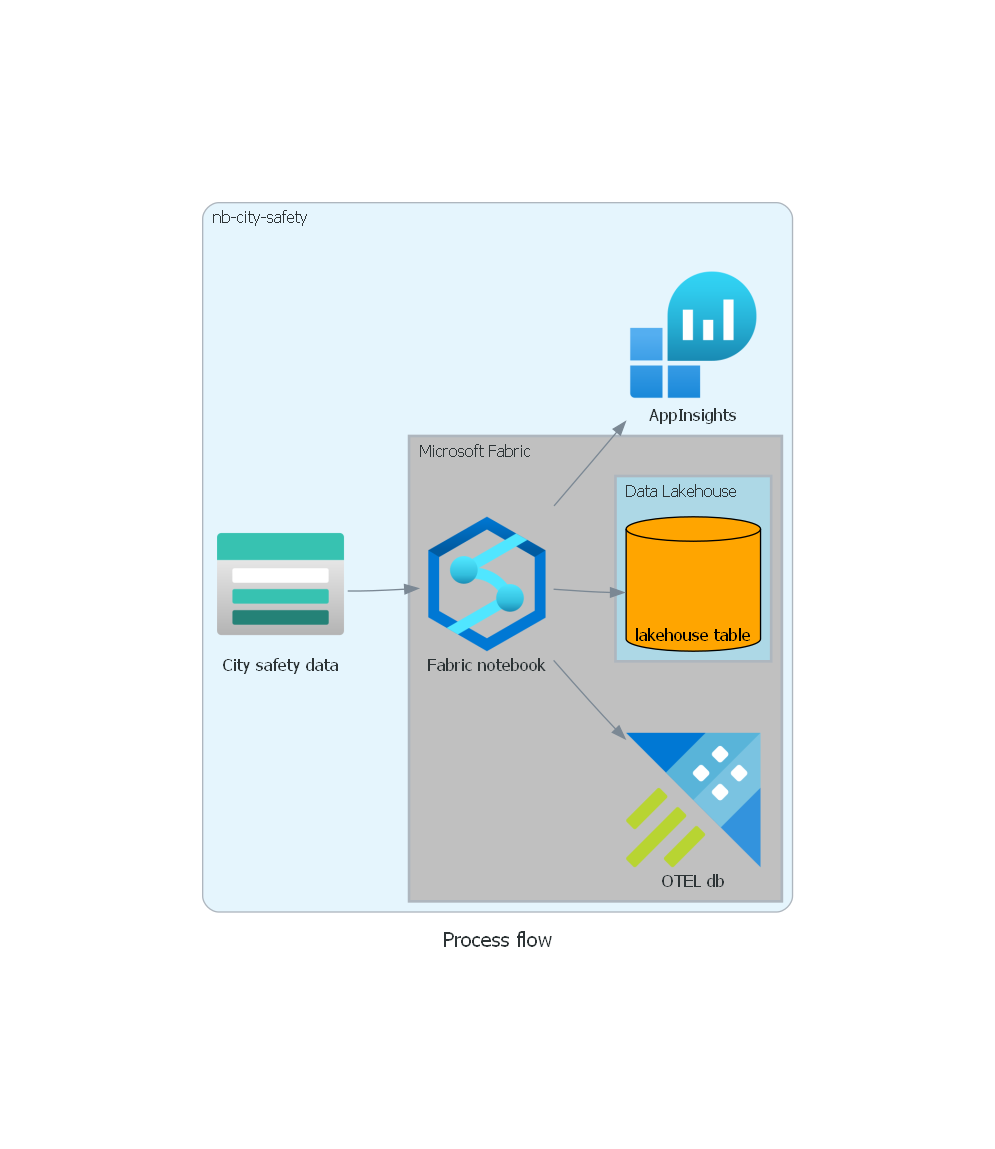

**Telemetry instrumentation flow diagram code**

```
from diagrams import Diagram, Cluster, Node, Edge

# for complete list of attributes: https://graphviz.org/docs/attrs/
with Diagram("OpenTelemetry Trace output", show=False, direction="LR"):  # Graph attributes: https://graphviz.org/docs/graph/ # , curvestyle="curved" 

    with Cluster(label="Trace", graph_attr={"style": "bold", "color": "blue"}): # Cluster attributes: https://graphviz.org/docs/clusters/ 
    
        with Cluster(label="Root span", direction="LR", graph_attr={"style": "bold", "bgcolor": "grey", "color": "black"}):

            root_child_spans = Cluster(label="etl_steps span", direction="LR", graph_attr={"style": "dotted", "bgcolor": "lightblue", "color": "black"}) 

            with root_child_spans:  
                third_child_span = Node(label="City xyz span", shape="promoter",  labelloc="b", style="filled", fillcolor="orange", color="black", fontcolor="black") # node attributes: https://graphviz.org/docs/nodes/
                second_child_span = Node(label="City def span", shape="promoter",  labelloc="b", style="filled", fillcolor="brown", color="black", fontcolor="black")
                first_child_span = Cluster(label="City abc span", graph_attr={"style": "bold", "fontcolor": "blue"})
                
                with first_child_span:  
                    data_activities = Node(label="ingestion acvy | processing acvy| load acvy", shape="record", style="dotted", fontcolor="blue")  

        data_activities >> second_child_span >> third_child_span
```

Here There is a *root span* under which all other child/nested spans are created. Under this *rootspan* - we have one *etl_steps_span* which acts as the parent span for each of the city level span i.e., a span while processing for a city (*city level span*) is created as a nested span under *etl_steps_span*. In our example, this process is pretty isolated and has no upstreams/downstream processes. In cases where is part of a pipeline of processes, then we should ensure to maintain Correlation ids (by using ingecting context from upstream processes). 

TO DO: Give examples here.

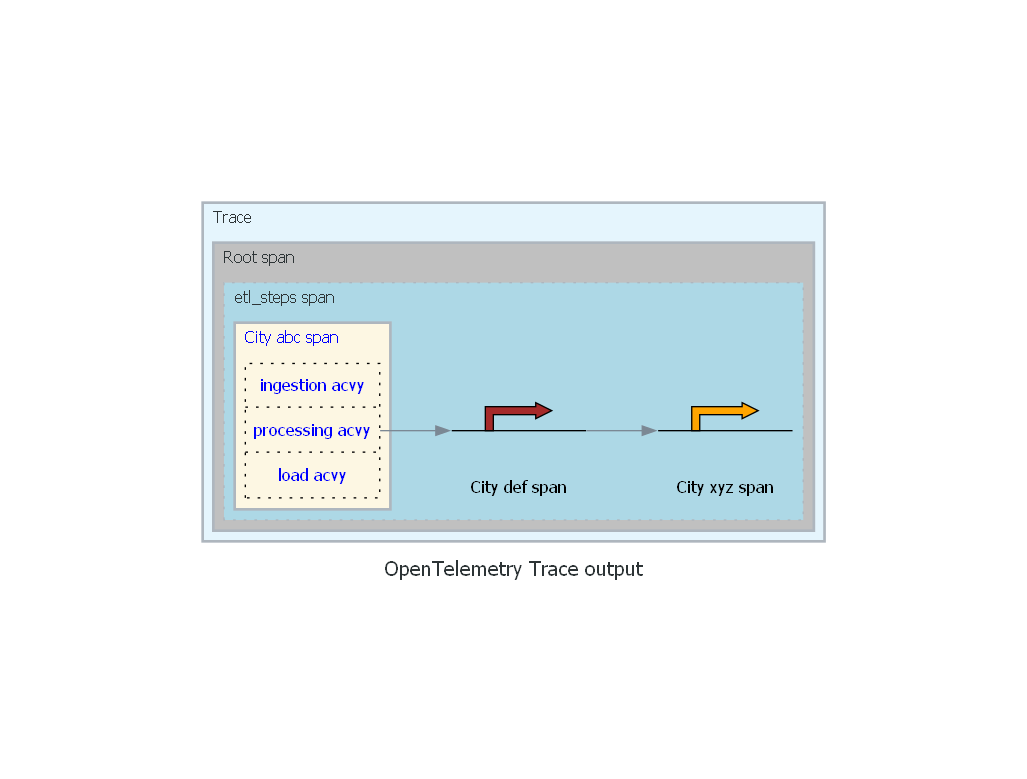

## Things to consider - general guidance, best practices

Here are a few things to consider while building a data process/system. Refer to [things to consider](../../docs/ThingsToConsiderForDataProcesses.md) for details. Please note that this is not an ehaustive list but enough for a good start of a data project.

- [Document the assumptions and known limitations]().
- [Know the KPIs]().
- [Follow proper linting and formatting](../../docs/ThingsToConsiderForDataProcesses.md#formatting-the-notebook).
- [Make security a priority](Secure the application/setup).
- [Organize code](../../docs/ThingsToConsiderForDataProcesses.md#organize-code) efficiently using libraries/modules [Understand making calls to other notebooks/code modules]().
- [Make the code configuration driven](../../docs/ThingsToConsiderForDataProcesses.md#make-the-code-configuration-driven).
- [plan for testing from day one]().
- [Implement monitoring and observability]()
  - setup - Know the tech stack - understand exiting tools and compatability, scability and security, encruption, data privacy, treatment of NPI data
  - Understand spans creation
  - Define resource attributes - using common schema
  - Proper naming conventions
- Combining Operations with Business data
- Visualizations
- Maintenance tools

## Formatting the Notebook - Run only when developing the Notebook
Reference: https://learn.microsoft.com/en-us/fabric/data-engineering/author-notebook-format-code#extend-fabric-notebooks ]

```python
import jupyter_black
jupyter_black.load()
```

## Parameters

- This example shows combination of two options: 1. sending default lake house information using run item api call and 2. using parameters cell and using absolute paths

#### CHECK WITH ANUJ - WHERE to HOST the CONFIG FILE - for now placing in notebooks folder 
- Our code currently assumes this is placed notebook resource folder. This can be part of the common ADLS path and we can attempt to read directly from there or copy from there to notebook during runtime.
  

#### External parameters

In [ ]:
# ------------------- Keep Only External parameters in this cell. --------------------------------------------
execution_mode = "all"  # "all" to run including tests; "normal" to exclude tests; "module" to exclude execution of code
common_execution_mode = "normal"
config_file_path = f"{mssparkutils.nbResPath}/builtin/city_safety.cfg"  # TIP: use same config but write code to replace what values to use - pay attention to interpolation
env_stage = "dev"
process_name = None
user_name = None
cleanup_flag = False  # True for table re-creation otherwise append
otel_setup_type = "monitor"  # allowed values are "monitor" for AppInsights as target using OTEL SDK for Azure monitor; and "collector" for OTEL collector based setup with configureable target/s.
# This could be treated as a business friendly correlatation id.
job_exec_instance = None
# Use either override_config_file_path or param_override
override_config_file_path = None  # Related to Option 1 in param override
param_override_flag = True  # Related to Option 2 in param override

In [ ]:
import json
from datetime import datetime
import configparser

config = configparser.ConfigParser(interpolation=configparser.ExtendedInterpolation())
# current_ts will act as a uniq execution tag when used in names
#  - Optionally bind with user input to identify child invocations
current_ts = datetime.utcnow().strftime("%Y%m%d%H%M%S")

#### Parameter overrides

In [ ]:
# ================= Overides for local testing  =================
# In this example - we are using both options together.

# ---------- Option 1 - Using a local override file
if override_config_file_path:  # Avoid accidential usage of overrides
    config_files = [
        config_file_path,
        override_config_file_path,
    ]  # order is important - last file overwrites the previous one
else:
    config_files = config_file_path

config.read(config_files)
# ---------- Option 2 - Directly override the values after reading the external config file
# Avoid accidential usage of overrides
if param_override_flag is not None and str(param_override_flag).lower() == "true":
    config["target"]["lakehouse_table_name"] = "tbl_city_safety_data_test"
    # allowed values for cities ("Boston", "Chicago", "NewYorkCity", "Seattle", "SanFrancisco")
    config["source"]["cities"] = json.dumps(("Boston",))
    config["otel"]["log_level"] = "INFO"

#### Additional paramater defaults

- Handle the scenario where user hasn't provided all the parametes needed. The following parameters help us identifying the data related to an execution. Make sure those are set to some meaningful values.

In [ ]:
# Set default values if not set in the config or by the user.
# - These will help us identifying data related to a run.
process_name = (
    process_name
    if process_name
    else config["process"].get(
        "process_name", notebookutils.runtime.context["activityId"]
    )
)
job_exec_instance = (
    job_exec_instance if job_exec_instance else f"{process_name}#{current_ts}"
)
# mssparkutils.env* will not work in runtime 1.3
user_name = user_name if user_name else mssparkutils.env.getUserName()

### Reference data
- We can put this PROCESS Contents  as a file config file and then import it as module

##### TO DO: Discuss with Anuj on where to keep this reference data

## Monitoring and observability

- We use Opentelemetry in this setyup - explain targets.

#### Open telemetry library - Need to add authentication and extensions

In [ ]:
# Run only once per environement - tracer, logger, meter should be global. Details:
# - Applications should generally use a single global TracerProvider, and
#   use either implicit or explicit context propagation consistently throughout.
#   See following sections to see different ways of creating traces.
#   Reference: https://opentelemetry-python.readthedocs.io/en/stable/api/trace.html

if otel_setup_type == "collector":
    # OTEL Collector based version - Collector based impletation with configurable targets
    #  Ensure collector is setup, running and accepting requests from the Notebook.
    import builtin.otel_invoker as otel_invoker

    otlp_exporter = otel_invoker.OpenTelemetryExporter(
        config["otel"]["port_type"], config["otel"]["otel_collect_ip"]
    )
elif otel_setup_type == "monitor":
    # OTEL Azure Monitor based version - used OpenTelemetry SDK based connection to Azure AppInsigths
    import builtin.otel_monitor_invoker as otel_invoker

    connection_string = notebookutils.credentials.getSecret(
        config["keyvault"]["uri"], config["otel"]["appinsights_connection_name"]
    )
    otlp_exporter = otel_invoker.OpenTelemetryAppInsightsExporter(
        conn_string=connection_string
    )
else:
    raise ValueError(
        "Given {otel_setup_type =} is not valid. Allowed values are 'monitor' and 'collector'."
    )

## Code implementation

### Define OpenTelemetry resources using common telemetry module
#### Understand spans creation
#### Define resource attributes - using common schema

In [ ]:
# Resource references
# - Naming conventions: https://opentelemetry.io/docs/specs/semconv/general/attribute-naming/
# - For a complete list of reserved ones: https://opentelemetry.io/docs/concepts/semantic-conventions/
# NOTE: service.namespace,service.name,service.instance.id triplet MUST be globally unique.
#     The ID helps to distinguish instances of the same service that exist at the same time
#     (e.g. instances of a horizontally scaled service)

# mssparkutils.env.* are not working in 3.5
# { k: v for k, v in spark.sparkContext.getConf().getAll() }
resource_attributes = {
    # ---------- Reserved attribute names
    "service.name": config["process"]["service_name"],
    # service.name = opentelemetry.sdk.resources.SERVICE_NAME
    "service.version": config["process"]["service_version"],
    "service.namespace": "domain-info",  # need to update this one - use process info
    "service.instance.id": notebookutils.runtime.context["activityId"],
    "process.executable.name": process_name,
    "deployment.environment": env_stage,
    # ---------- custom attributes - we can also add common attributes like appid, domain id etc
    #     here or get them from process reference data using processname as the key.
    "jobexec.fabric.capacityid": spark.sparkContext.getConf().get(
        "spark.hadoop.trident.capacity.id"
    ),
    "jobexec.cluster.id": spark.sparkContext.getConf().get("spark.cluster.name"),
    "jobexec.cluster.name": spark.sparkContext.getConf().get("spark.fabric.pool.name"),
    "jobexec.cluster.region": spark.sparkContext.getConf().get("spark.cluster.region"),
    "jobexec.fabric.envdetails": spark.sparkContext.getConf().get(
        "spark.fabric.environmentDetails"
    ),
    "jobexec.app.name": spark.sparkContext.getConf().get("spark.app.name"),
    "jobexec.instance.name": job_exec_instance,
    "jobexec.context": f"{notebookutils.runtime.context}",  # convert to string otherwise it will fail
    "jobexec.userid": "mssparkutils.env.getUserId()",  # need to find a way to get this
    "jobexec.username": "mssparkutils.env.getUserName()",  # need to find a way to get this
    "jobexec.workspaceid": spark.sparkContext.getConf().get(
        "spark.hadoop.trident.workspace.id"
    ),
}

#### Create Opentelemetry providers

In [ ]:
# - Usually logging is done with in the context of a Span. This means - each
#   log message can be joined with trace information using spanid and traceid.
#   For this reason we can choose to keep the resources information for logging
#   to a minimum (as they are already part of the span/trace) or keep custom resources which are
#   relavant to that log message.
#   Note that traceid and spanid will be null when logging is done outside of a span context.
log_attributes = {"service.name": "otel-poc-vm-based"}

# For conveneience, in this example we are using same resource_attributes for traces and metrics.
trace_attributes = metrics_attributes = resource_attributes

try:
    tracer
except NameError:
    print("Telemetry providers aren't set yet. Defining now..")
    # Global providers for traces, logs and metrics - Only need to be run once per session
    tracer = otlp_exporter.get_otel_tracer(trace_attributes)
    logger = otlp_exporter.get_otel_logger(log_attributes)
    logger.setLevel(config["otel"]["log_level"])  # deafult is WARN
    meter = otlp_exporter.get_otel_metrics(metrics_attributes)
    counter = meter.create_counter(
        name="city-level-metrics", description="Counts at city level", unit="1"
    )
else:
    print(
        "Telemetry providers are defined already. Process will continue with the same global providers."
    )

### Library functions

- Makes the functions available to local session. Only functions definitions any other common params needed are defined in this library notebook. Shown here with an optional parameter that can be used to skip some portion of the code inside a cell.
- These functions incorporate Opentelemetry based traces and logs generation using the OpenTelemetry providers created in the previous step. See the code in nb_city_safety_common.ipynb for details.
- Note that the entire notebook will be run.
- **WARNING**: If there are any variables with the same name then the notebook values that is being called will replace the values in the current notebook context. In the example below - `%run nb_city_safety_common {"execution_mode": "testing"}` will result in `execution_mode = "testing" ` in current context as well.


In [ ]:
%run nb_city_safety_common { "common_execution_mode": "normal" }

### TO DO: DQ
- Add integration with Purview
- Greatexpectations usgae (static - aggregate metrics)
- Record level checks (custom dq engine)

### Main function - Set local parameters, create root span and run the process

In [ ]:
# ================== Globals section ======================================
# During unit tests these are some of the values we will be overwriting with test values.
# mssparkutils.env.* are not working in 3.5
spark_major_version = float(".".join(spark.version.split(".")[:2]))
# this is a tuple so using json load to read it properly
cities = json.loads(config["source"]["cities"])
# read configs is done in the very begining
workspace_name = (
    f'{config["target"]["workspace_name_prefix"]}-{env_stage}'
    if env_stage
    else config["target"]["workspace_name_prefix"]
)
# notebookutils.workspace.* aren't ready yet - so we need this code to obtain workspace id
ws_name_encoded = urllib.parse.quote(workspace_name)
ws_url = f"https://api.fabric.microsoft.com/v1/admin/workspaces?name={ws_name_encoded}"
token = notebookutils.credentials.getToken("pbi")
response = make_fabric_api_call(token=token, url=ws_url, call_type="get", payload={})
ws_status, ws_headers, ws_json = response.status_code, response.headers, response.json()
if ws_status == 200 and len(ws_json["workspaces"]) > 0:
    workspace_id = ws_json["workspaces"][0]["id"]
else:
    raise ValueError(f"{workspace_name =} isn't returning a valid workspace_id.")
    print(f"{ws_status = }\n\n{ws_json =}")
# Lakehouse name doesn't allow spaces - however if we are using workspace_id in adfss path then this also must be an id.
lakehouse_name = config["target"]["lakehouse_name"]
lakehouse_id = notebookutils.lakehouse.get(
    name=lakehouse_name, workspaceId=workspace_id
)["id"]
lakehouse_table_name = config["target"]["lakehouse_table_name"]
onelake_name = config["target"]["onelake_name"]
# Complete paths - allows us to connect to any workspace and any lake house as long we have the proper access.
# The following could cause issues if we have spaces in workspace name, so using ids instead.
#   onelake_path = f"abfss://{workspace_name}@{onelake_name}.dfs.fabric.microsoft.com/{lakehouse_name}.lakehouse"
onelake_path = (
    f"abfss://{workspace_id}@{onelake_name}.dfs.fabric.microsoft.com/{lakehouse_id}"
)
onelake_file_path = f"{onelake_path}/Files"
onelake_table_path = f"{onelake_path}/Tables"

# ------------- Common globals from Config file ------------------------#
# Used these directly - ex: config["source"]["blob_container_name"]

# ------------- ENV/Stage spefic globals derived in the code ------------------------#
#  NOTE: When creating stage specific resources like ADLS (whose names are globally unique),
#      make sure we can create/access them ie that name is still available for us.
blob_account_name = (
    f'{config["source"]["blob_account_name_prefix"]}{env_stage}'
    if env_stage
    else config["source"]["blob_account_name_prefix"]
)
blob_sas_token = notebookutils.credentials.getSecret(
    config["keyvault"]["uri"], f'{config["keyvault"]["secret_name_prefix"]}-{env_stage}'
)

# -------- Allow Spark remote read ------------------
# WARNING: NEVER EVER do this. We are changing how data reads work (WASBS VS ABFSS)
# - which means each environment will have different behavior,
#   and this will result in untested code/behavior in higher envs.
#   Correct way is to use same protocol/technology in all envs.
if env_stage == "dev":
    storage_type, storage_end_point_type = "abfss", "dfs"
else:
    storage_type, storage_end_point_type = "wasbs", "blob"
# --------------------------------------------

wasbs_path = f'{storage_type}://{config["source"]["blob_container_name"]}@{blob_account_name}.{storage_end_point_type}.core.windows.net/{config["source"]["blob_relative_path"]}'
spark.conf.set(
    f'fs.azure.sas.{config["source"]["blob_container_name"]}.{blob_account_name}.{storage_end_point_type}.core.windows.net',
    blob_sas_token,
)

logger.info(f"{wasbs_path =}\n{blob_account_name =}")

In [ ]:
# Main function - Read Microsoft Open data sets and load the target table
# Telemetry reference: https://github.com/open-telemetry/opentelemetry-python/blob/stable/docs/examples/logs/example.py
def main():

    with tracer.start_as_current_span(
        f"root#nb-safety#{current_ts}", kind=SpanKind.INTERNAL
    ) as root_span:

        try:
            root_span.set_attributes(
                {
                    "etl.workspace_name": workspace_name,
                    "etl.cities": cities,
                    "etl.lakehouse_table_name": lakehouse_table_name,
                }
            )
            logger.info(
                f"{workspace_name = }\n{wasbs_path =}\n{blob_account_name =}\n{cities = }\n{lakehouse_table_name = }"
            )

            verify_onelake_connection()
            etl_steps(
                table_name=lakehouse_table_name, cities=cities, cleanup=cleanup_flag
            )
            # TO DO: ADD some DQ checks

            # Prepare for metrics publish using OpenTelemetry
            gather_city_level_metrics(table_name=lakehouse_table_name, counter=counter)

        except Exception as e:
            logger.exception(f"ETL step failed with error {e}")
            root_span.set_status(StatusCode.ERROR, f"ETL step failed with error {e}")
            root_span.record_exception(e)
            raise
        else:
            root_span.set_status(StatusCode.OK)
        finally:
            logger.info("City safety processing is complete.")

In [ ]:
if execution_mode in ("normal", "all"):
    logger.info("Execution main function now...")
    main()
else:
    logger.info(f"Skipping execution based on the input {execution_mode =}")

## Visualize data

### Adding other aspects of monitoring - user data and security data
- monitoring hub data as of now is not available
- we can item execution apis and store those details periodically

### Kusto Queries 

- can we learn anything from App insights and use those queries here

- Combining operational data with business data

- basic visualizations using Kusto

- graph functionality in Kusto

In [ ]:
# WIP

# create the Powerb i report using either direct lake mode or kusto data



## Unit tests

We perform two types of testing:
1. Code focused - Involves patching and lot mocked code calls and minimal environment setup.
2. Data focused - Involves simulating data environments with minimal mocking of code calls.

Refer to [data testing](./DataTesting.md) on how to plan, create and run testcases.



### Unit tests - code focus

- This example shows Unit testing code hosted in the same notebook as the main code. Note the usage of `execution_mode` to control the testcase runs. 
- We are also setting `raise_on_error=False` so that failure of unit testcases will not cause a notebook failure. Instead these are captured in later steps and let the user decide on how to proceed further.

In [ ]:
if execution_mode in ("testing", "all"):
    import pytest
    import ipytest
    from unittest.mock import MagicMock, patch, call

    ipytest.autoconfig(
        raise_on_error=False
    )  # **NOTE** True will result in notebook failure; False will not cause notebook failure. We can then use our capture output to do any custom error handling.

    @patch("__main__.gather_city_level_metrics")
    @patch("__main__.etl_steps")
    @patch("__main__.verify_onelake_connection")
    @patch("__main__.tracer")
    def test_main(
        mock_tracer, mock_conn_check, mock_etl_steps, mock_metrics_gather, caplog
    ):
        caplog.clear()
        caplog.set_level(logging.INFO)

        exp_log_output = [
            f"{workspace_name = }",
            f"{cities = }",
            f"{lakehouse_table_name = }",
            "City safety processing is complete.",
        ]

        mock_conn_check.return_value = True
        mock_etl_steps.return_value = True
        mock_metrics_gather.return_value = True

        main()

        mock_span = (
            mock_tracer.start_as_current_span.return_value.__enter__.return_value
        )
        print(caplog.text)
        assert all(log in caplog.text for log in exp_log_output)
        # print(mock_tracer.mock_calls)
        assert (
            call.start_as_current_span().__enter__() in mock_tracer.mock_calls
        )  # <----trace (with) context call
        assert (
            mock_tracer.start_as_current_span.return_value.__enter__.call_count == 1
        )  # <----trace (with) context-start
        mock_span.set_attributes.assert_called_once_with(
            {
                "etl.workspace_name": workspace_name,
                "etl.cities": cities,
                "etl.lakehouse_table_name": lakehouse_table_name,
            }
        )
        assert mock_span.set_status.call_count == 1
        assert (
            mock_tracer.start_as_current_span.return_value.__exit__.call_count == 1
        )  # <--- trace (with) context-end

        # Check exception condition
        error_message = "Dummy failure on metrics gathering."
        mock_metrics_gather.side_effect = Exception(error_message)

        with pytest.raises(Exception) as exc:
            main()

        assert f"ETL step failed with error {error_message}" in caplog.text
        mock_span.set_status.call_count == 2
        assert exc.type == Exception
        assert str(exc.value) == error_message

In [ ]:
%%capture unit_tests_results
# %%ipytest - will run the test cases using the magic - instead we are using ipytest.run()
print(f"at the testing cell. {execution_mode = }")
if execution_mode in ("testing", "all"):
    print(f"running the test cases now. {execution_mode = }")
    ipytest.run()
else:
    logger.info("Skipping code based unit tests")

In [ ]:
if execution_mode in ("testing", "all"):
    store_unit_test_results(unit_tests_results) # as of now we are only printing the results
    # TO DO - how to sureface these results for the CI process

### Unit testing - data focus

This example shows Unit testing code hosted in [another notebook](../../tests/test_nb-city-safety.ipynb).

## Maintenace Utilities



It is important the system is maintained properly and optimized for resource utililization. Some of these include: cleaningup/archiving unused files, stopping compute resources when idle etc. See [maintenance utilities](../../docs/MaintenanceUtilities.md) for details on this topic.